In [54]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import GlorotNormal #(튜닝) 추가
from tensorflow.keras.activations import elu
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

LOSS_CLIPPING = 0.2

class Agent(object):
    def __init__(self):
        #(1) 환경 설정
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        #(2) 신경망 구조 및 학습률 설정
        self.node_num = 12
        self.actor_lr = 0.001
        self.critic_lr = 0.005
        self.epochs_cnt = 5
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        #(3) 할인율 및 GAE 파라미터 설정
        self.discount_rate = 0.98
        self.lambda_gae = 0.95
        self.penalty = -10

        #(4) 에피소드 수 및 이동 평균 설정
        self.episode_num = 500
        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        #(5) 학습 데이터를 저장할 리스트 초기화
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        self.old_probs = []

    #(1) 정책 신경망 생성
    def build_actor(self):
        input_states = Input(shape=(self.state_size,), name='input_states')

        # (튜닝) glorot_normal 초기화, Swish 활성화 함수
        x = Dense(self.node_num, activation='swish', kernel_initializer=GlorotNormal())(input_states)  
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)

        model = tf.keras.models.Model(inputs=input_states, outputs=out_actions)

        # (튜닝) clipnorm 설정
        model.compile(optimizer=Adam(learning_rate=self.actor_lr, clipnorm=1.0))
        model.summary()
        return model

    #(2) 가치 신경망 생성
    def build_critic(self):
        input_states = Input(shape=(self.state_size,), name='input_states')

        # (튜닝) glorot_normal 초기화, Swish 활성화 함수
        x = Dense(self.node_num, activation='swish', kernel_initializer=GlorotNormal())(input_states)  
        out_value = Dense(1, activation='linear', name='value')(x)

        model = tf.keras.models.Model(inputs=input_states, outputs=out_value)
        
        # (튜닝) clipnorm 설정
        model.compile(optimizer=Adam(learning_rate=self.critic_lr, clipnorm=1.0), loss='mean_squared_error')
        model.summary()
        return model

    def train(self):
        for episode in range(self.episode_num):
            #(1) 에피소드 초기화
            state, _ = self.env.reset()
            reward_tot = 0
            step_count = 0
            done = False

            while not done:
                #(2) 에이전트의 환경 탐험
                action, prob = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                #(3) 조기 종료에 대한 보상 패널티 적용
                if done and step_count < 499:
                    reward = self.penalty

                #(4) 경험 저장 및 상태 전이
                self.store_transition(state, action, reward, done, next_state, prob)
                state = next_state
                reward_tot += reward
                step_count += 1

            #(5) 보상 및 통계 저장
            self.reward_list.append(reward_tot - self.penalty)
            self.count_list.append(step_count)
            self.moving_avg_list.append(np.mean(self.reward_list[-self.moving_avg_size:]))

            #(6) 정책 및 가치 신경망 업데이트
            self.update_models()
            self.clear_memory()

            #(7) 주기적인 학습 상황 출력
            if episode % 10 == 0:
                moving_avg = np.mean(self.reward_list[-self.moving_avg_size:])
                reward_avg = np.mean(self.reward_list)
                print(f"episode:{episode}, moving_avg:{moving_avg:.2f}, rewards_avg:{reward_avg:.2f}")

        #(8) 모델 저장
        self.save_model()

    def get_action(self, state):
        #(1) 상태 입력 형태 변환
        state_input = np.reshape(state, [1, self.state_size]).astype(np.float32)

        #(2) 정책 신경망을 통해 행동 확률 분포 예측
        prob = self.actor(state_input, training=False).numpy()[0]

        #(3) 확률적으로 행동 선택
        action = np.random.choice(self.action_size, p=prob)

        #(4) 행동과 확률 분포 반환
        return action, prob

    def store_transition(self, state, action, reward, done, next_state, prob):
        #(1) 행동을 원-핫 벡터로 변환
        action_onehot = np.zeros(self.action_size)
        action_onehot[action] = 1.0

        #(2) 경험 데이터 저장
        self.states.append(state)
        self.actions.append(action_onehot)
        self.rewards.append(reward)
        self.dones.append(done)
        self.next_states.append(next_state)
        self.old_probs.append(prob)

    def update_models(self):
        #(1) 수집된 데이터를 배열로 변환
        states = np.array(self.states, dtype=np.float32)
        next_states = np.array(self.next_states, dtype=np.float32)
        rewards = np.array(self.rewards, dtype=np.float32).reshape(-1, 1)
        dones = np.array(self.dones, dtype=np.int32).reshape(-1, 1)
        actions = np.array(self.actions, dtype=np.float32)
        old_probs = np.array(self.old_probs, dtype=np.float32)

        #(2) GAE를 활용한 어드벤티지 및 타깃 계산
        advantages, targets = self.compute_gae(states, next_states, rewards, dones)
        advantages -= np.mean(advantages)
        advantages /= (np.std(advantages) + 1e-8)

        advantages = advantages.astype(np.float32)
        targets = targets.astype(np.float32)

        for _ in range(self.epochs_cnt):
            #(3) Actor 업데이트를 위한 손실 함수 계산
            with tf.GradientTape() as tape:
                probs = self.actor(states, training=True)
                new_probs = tf.reduce_sum(actions * probs, axis=1, keepdims=True)
                old_probs_sum = tf.reduce_sum(actions * old_probs, axis=1, keepdims=True)

                ratio = new_probs / (old_probs_sum + 1e-10)
                clipped_ratio = tf.clip_by_value(ratio, 1 - LOSS_CLIPPING, 1 + LOSS_CLIPPING)
                actor_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))

            #(4) Actor 모델의 파라미터 업데이트
            gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor.optimizer.apply_gradients(zip(gradients, self.actor.trainable_variables))

            #(5) Critic 모델의 타깃 학습
            self.critic.train_on_batch(states, targets)

    def compute_gae(self, states, next_states, rewards, dones):
        #(1) 현재 상태와 다음 상태의 가치 예측 
        values = self.critic(states, training=False).numpy()
        next_values = self.critic(next_states, training=False).numpy()

        #(2) 어드벤티지와 타깃 배열 초기화
        advantages = np.zeros_like(rewards, dtype=np.float32)
        targets = np.zeros_like(rewards, dtype=np.float32)

        #(3) GAE 누적 계산 초기화
        gae = 0.0

        #(4) 시간 순서 역순으로 GAE 계산
        for t in reversed(range(len(rewards))):
            #(5) 델타 값 계산
            delta = rewards[t] + self.discount_rate * next_values[t] * (1 - dones[t]) - values[t]

            #(6)  GAE 누적 계산
            gae = delta + self.discount_rate * self.lambda_gae * (1 - dones[t]) * gae

            #(7) 어드벤티지와 타깃 계산
            advantages[t] = gae
            targets[t] = gae + values[t]
        #(8) 최종 결과 반환
        return advantages, targets
		
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        self.old_probs = []

    def save_model(self):
        os.makedirs("./model", exist_ok=True)
        self.actor.save("./model/ppo_actor.keras")
        self.critic.save("./model/ppo_critic.keras")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense_69 (Dense)            (None, 12)                60        
                                                                 
 output (Dense)              (None, 2)                 26        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense_70 (Dense)            (None, 12)     

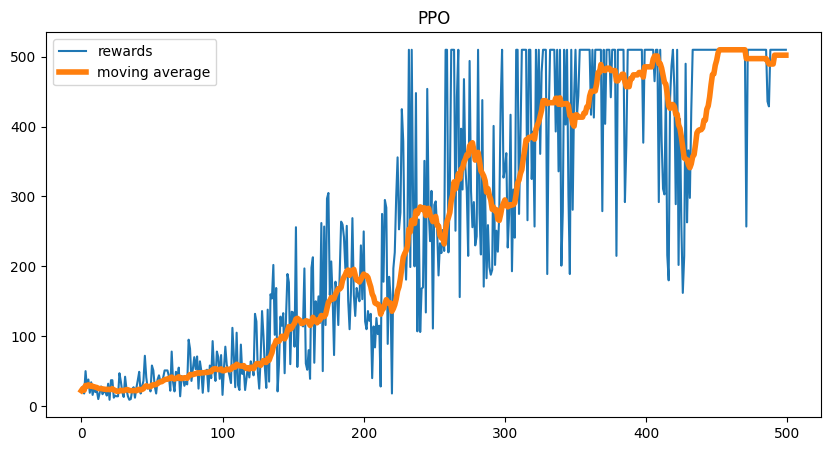

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('PPO')
plt.show()